In [346]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [256]:
products_cl = pd.read_csv("my_products.csv")
orders_qu = pd.read_csv("orders_qu.csv")
orderlines_qu = pd.read_csv("orderlines_qu.csv")
brands = pd.read_csv("brands.csv")
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_colwidth", 100)

In [257]:
olo_qu=orderlines_qu.merge(orders_qu, how="left", left_on="id_order", right_on="order_id")
olop_qu = olo_qu.merge(products_cl, how="left", on="sku").drop(["product_id", "created_date","id", "state","in_stock", "id_order"], axis=1)
olop_qu["order_difference"] = olop_qu["price"] - olop_qu["unit_price"]
# olop_qu['created_date'] = pd.to_datetime(olop_qu['created_date']).dt.date
olop_qu['date'] = pd.to_datetime(olop_qu['date'])#.dt.date

In [258]:
def get_category(price):
    if price < 90:
        return 'Accessories'
    elif price < 200:
        return 'Budget Tech'
    elif price < 500:
        return 'Mid-Range Tech'
    elif price < 1000:
        return 'High-End Tech'
    else:
        return 'Premium Tech' 
    
def get_discount_type(Discount):
    if Discount < 10:
        return 'low or no'
    elif Discount < 25:
        return 'normal'
    elif Discount < 50:
        return 'high'
    else:
        return 'agressive' 

In [259]:
olop_qu['category'] = olop_qu['price'].apply(get_category)
olop_qu.loc[olop_qu["desc"].str.contains("Refurbished", case=False), "category"] = "Second Hand"

In [ ]:
grouped = olop_qu.groupby('date').agg({'order_id': 'count', 'unit_price': 'mean'})
plt.figure(figsize=(10, 5))
plt.plot(grouped.index, grouped['order_id'], label='Orders')
plt.xlabel('Date')
plt.ylabel('Amount of orders')
plt.title('Orders over Time')
plt.legend()
plt.show()

In [260]:
olop_qu["short"] = olop_qu["sku"].str[:3]
olopb_qu = olop_qu.merge(brands, how="left", on="short")

In [261]:
categories_df = (olopb_qu.groupby("category", as_index=False)
                           .agg({"product_quantity":"sum", "total_paid":"sum",
                             "price":"mean", "unit_price":"mean",
                             "order_difference":"mean"})
                         .nlargest(10, "product_quantity"))
categories_df

,category,product_quantity,total_paid,price,unit_price,order_difference
0,Accessories,33517,3455882.61,45.207698,33.870410,11.337287
1,Budget Tech,14167,2548748.87,137.352069,111.424717,25.927352
3,Mid-Range Tech,8748,2937579.50,333.356128,282.888378,50.467750
2,High-End Tech,3738,2504542.64,706.498253,596.833559,109.664693
5,Second Hand,541,271414.06,635.926130,467.611897,168.314234
4,Premium Tech,294,284338.18,1118.299161,894.912727,223.386434


In [277]:
discounts_df=olopb_qu.loc[:, ["category", "long", "name", "order_id", "product_quantity", "price", "date", "unit_price", "order_difference"]]
# discounts_df["planned_discount"]= 100-discounts_df["promo_price"]*100/discounts_df["price"]
discounts_df["actual_revenue"]= discounts_df["product_quantity"]*discounts_df["unit_price"]
discounts_df["Discount"]= 100-discounts_df["unit_price"]*100/discounts_df["price"]
discounts_df["discount_type"]=discounts_df['Discount'].apply(get_discount_type)

discounts_df.sample(5)

,category,long,name,order_id,product_quantity,price,date,unit_price,order_difference,actual_revenue,Discount,discount_type
35100,Accessories,Tucano,"Tucano Nido Hard-Shell Case MacBook Pro 15 ""(late 2016) Transparent",446861,1,34.9,2017-11-27 03:31:27,25.49,9.41,25.49,26.962751,high
23558,High-End Tech,Apple,Apple iPhone 64GB Silver 8,403439,1,809.0,2017-09-22 21:47:12,807.33,1.67,807.33,0.206428,low or no
25558,Mid-Range Tech,Cyberpower,PFC Sinewave CyberPower 1300VA 780W UPS System,411582,2,250.0,2017-10-11 20:19:46,199.99,50.01,399.98,20.004000,normal
38927,Accessories,Apple,IPhone AppleCare Protection Plan,464950,2,70.0,2017-12-17 17:57:21,56.00,14.00,112.00,20.000000,normal
3151,Accessories,Lexar,Lexar JumpDrive Lightning USB 3.0 M20i Pendrive 32GB,310041,1,62.0,2017-01-15 23:07:23,35.99,26.01,35.99,41.951613,high


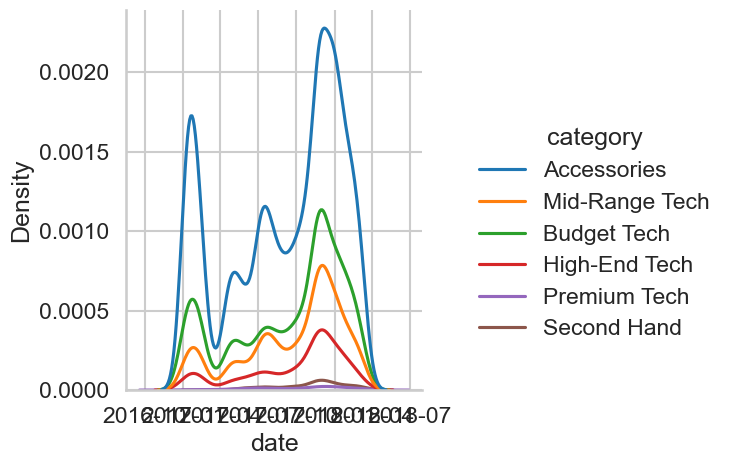

In [278]:
discounts_df['year_month'] = discounts_df['date'].dt.strftime('%Y-%m')
sns.displot(kind="kde",
            data=discounts_df, 
            x="date",
            hue="category");

In [280]:
orders_by_category_month_year=discounts_df.groupby(['category', 'year_month']).agg({'order_id': 'count', "product_quantity":"sum", 'actual_revenue': 'sum',"price":"mean","unit_price":"mean", 'order_difference': 'mean', "Discount":"mean"})
#orders_by_category_month_year.loc[orders_by_category_month_year["category"]=="Second Hand", :]
#orders_by_category_month_year=orders_by_category_month_year.sort_values(by="year_month")
orders_by_category_month_year

order_id  product_quantity  actual_revenue  \
category       year_month                                               
Accessories    2017-01         3957              4571       139324.25   
               2017-02         1501              1752        58070.21   
               2017-03          136               147         5463.18   
               2017-04         1106              1272        43974.19   
               2017-05         1203              1483        53669.69   
               2017-06          973              1197        41602.27   
               2017-07         2360              2678        83811.72   
               2017-08         1470              1677        55140.20   
               2017-09         1338              1541        51414.66   
               2017-10         1901              2140        71024.86   
               2017-11         3795              4338       142563.89   
               2017-12         3265              3640       129078.95   
               2018-01         3221              3648       125178.29   
               2018-02         2030              2299        79898.40   
               2018-03          957              1134        41004.49   
Budget Tech    2017-01         1361              1527       158018.47   
               2017-02          656               734        82604.00   
               2017-03           52                63         7276.46   
               2017-04          482               532        55399.65   
               2017-05          537               604        70717.26   
               2017-06          366               420        47857.57   
               2017-07          793               916        95350.76   
               2017-08          611               694        79941.10   
               2017-09          561               602        70557.07   
               2017-10          856               992       114472.38   
               2017-11         2273              2675       306615.89   
               2017-12         1285              1424       164038.78   
               2018-01         1415              1568       162655.24   
               2018-02          951              1049       118674.28   
               2018-03          346               367        43331.07   
High-End Tech  2017-01          260               268       144611.81   
               2017-02          134               141        84856.14   
               2017-03            8                 8         5714.96   
               2017-04           87                90        46875.90   
               2017-05          120               133        78282.22   
               2017-06          141               152        91455.68   
               2017-07          225               226       134208.62   
               2017-08          156               160        82997.68   
               2017-09          195               208       127968.61   
               2017-10          266               273       168943.76   
               2017-11          797               826       498742.17   
               2017-12          457               482       307234.10   
               2018-01          444               478       283577.07   
               2018-02          196               204       117849.72   
               2018-03           85                89        49690.68   
Mid-Range Tech 2017-01          601               634       173227.18   
               2017-02          327               355        98193.00   
               2017-03           24                28         7054.75   
               2017-04          249               274        81919.29   
               2017-05          313               364       106577.92   
               2017-06          252               279        78200.82   
               2017-07          729               791       243020.70   
               2017-08          481               519       141341.17   
            

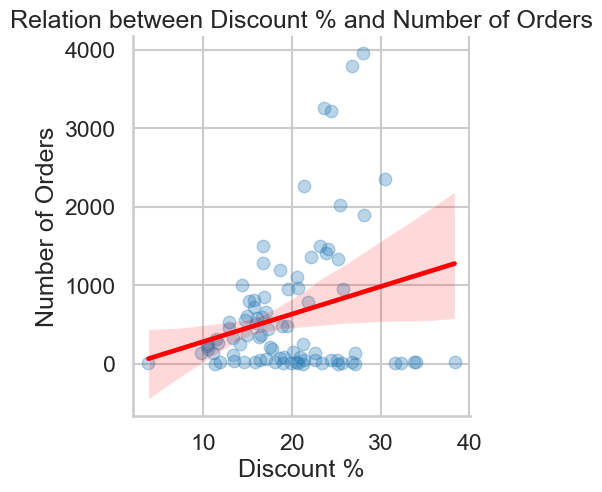

In [281]:
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the scatter plot with a linear regression line
sns.lmplot(x="Discount", y="order_id", data=orders_by_category_month_year, 
           scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})

# Add labels and title
plt.xlabel("Discount %")
plt.ylabel("Number of Orders")
plt.title("Relation between Discount % and Number of Orders")

# Show the plot
plt.show()

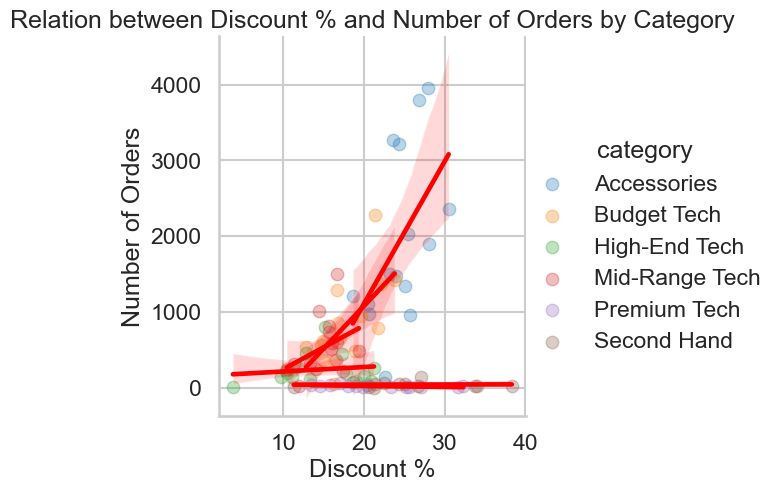

In [282]:
orders_by_category_m_y = orders_by_category_month_year.reset_index()

sns.set_style("whitegrid")
sns.set_context("talk")

# Create the scatter plot with a linear regression line and color code by category
sns.lmplot(x="Discount", y="order_id", data=orders_by_category_m_y, hue="category", 
           scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})

# Add labels and title
plt.xlabel("Discount %")
plt.ylabel("Number of Orders")
plt.title("Relation between Discount % and Number of Orders by Category")

# Show the plot
plt.show()

In [285]:
# orders_by_category_month_year["product_increase"]=
# orders_by_category_month_year["Discount_increase"]=
orders_by_category_month_year["orders_increase"] = round(orders_by_category_month_year["order_id"].pct_change(), 1)
orders_by_category_month_year["product_increase"] = round(orders_by_category_month_year["product_quantity"].pct_change(), 1)
orders_by_category_month_year


order_id  product_quantity  actual_revenue  \
category       year_month                                               
Accessories    2017-01         3957              4571       139324.25   
               2017-02         1501              1752        58070.21   
               2017-03          136               147         5463.18   
               2017-04         1106              1272        43974.19   
               2017-05         1203              1483        53669.69   
               2017-06          973              1197        41602.27   
               2017-07         2360              2678        83811.72   
               2017-08         1470              1677        55140.20   
               2017-09         1338              1541        51414.66   
               2017-10         1901              2140        71024.86   
               2017-11         3795              4338       142563.89   
               2017-12         3265              3640       129078.95   
               2018-01         3221              3648       125178.29   
               2018-02         2030              2299        79898.40   
               2018-03          957              1134        41004.49   
Budget Tech    2017-01         1361              1527       158018.47   
               2017-02          656               734        82604.00   
               2017-03           52                63         7276.46   
               2017-04          482               532        55399.65   
               2017-05          537               604        70717.26   
               2017-06          366               420        47857.57   
               2017-07          793               916        95350.76   
               2017-08          611               694        79941.10   
               2017-09          561               602        70557.07   
               2017-10          856               992       114472.38   
               2017-11         2273              2675       306615.89   
               2017-12         1285              1424       164038.78   
               2018-01         1415              1568       162655.24   
               2018-02          951              1049       118674.28   
               2018-03          346               367        43331.07   
High-End Tech  2017-01          260               268       144611.81   
               2017-02          134               141        84856.14   
               2017-03            8                 8         5714.96   
               2017-04           87                90        46875.90   
               2017-05          120               133        78282.22   
               2017-06          141               152        91455.68   
               2017-07          225               226       134208.62   
               2017-08          156               160        82997.68   
               2017-09          195               208       127968.61   
               2017-10          266               273       168943.76   
               2017-11          797               826       498742.17   
               2017-12          457               482       307234.10   
               2018-01          444               478       283577.07   
               2018-02          196               204       117849.72   
               2018-03           85                89        49690.68   
Mid-Range Tech 2017-01          601               634       173227.18   
               2017-02          327               355        98193.00   
               2017-03           24                28         7054.75   
               2017-04          249               274        81919.29   
               2017-05          313               364       106577.92   
               2017-06          252               279        78200.82   
               2017-07          729               791       243020.70   
               2017-08          481               519       141341.17   
            

In [289]:
orders_by_category_m_y["orders_increase"] = round(orders_by_category_m_y["order_id"].pct_change(), 1)
orders_by_category_m_y["actual_revenue_increase"] = round(orders_by_category_m_y["actual_revenue"].pct_change(), 1)
orders_by_category_m_y.groupby("category").agg({"orders_increase":"mean","actual_revenue_increase":"mean","Discount":"mean"})

,orders_increase,actual_revenue_increase,Discount
category,,,
Accessories,0.485714,0.464286,24.491784
Budget Tech,0.600000,0.646667,17.886859
High-End Tech,0.680000,0.686667,14.340969
Mid-Range Tech,1.086667,0.933333,15.056634
Premium Tech,0.371429,0.350000,21.691062
Second Hand,1.069231,3.592308,25.007726


In [292]:
orders_by_category_m_y.groupby("year_month").agg({"orders_increase":"mean","actual_revenue_increase":"mean","Discount":"mean"})

,orders_increase,actual_revenue_increase,Discount
year_month,,,
2017-01,1.325000,1.700000,23.014405
2017-02,-0.260000,-0.280000,19.262744
2017-03,-0.900000,-0.920000,15.184695
2017-04,6.033333,9.766667,17.591972
2017-05,1.616667,3.016667,18.215877
2017-06,-0.066667,-0.066667,18.532579
2017-07,1.116667,1.116667,20.549180
2017-08,-0.383333,-0.416667,21.901532
2017-09,0.466667,0.550000,19.239515


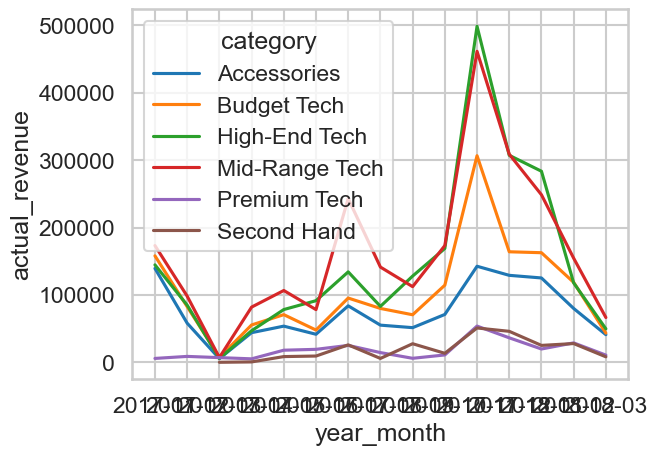

In [294]:
ax=sns.lineplot(x='year_month', y='actual_revenue', hue='category', data=orders_by_category_m_y);

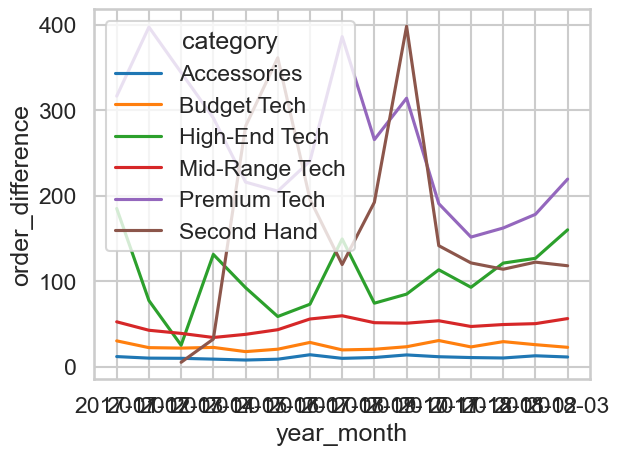

In [299]:
sns.lineplot(x='year_month', y='order_difference', hue='category', data=orders_by_category_month_year);

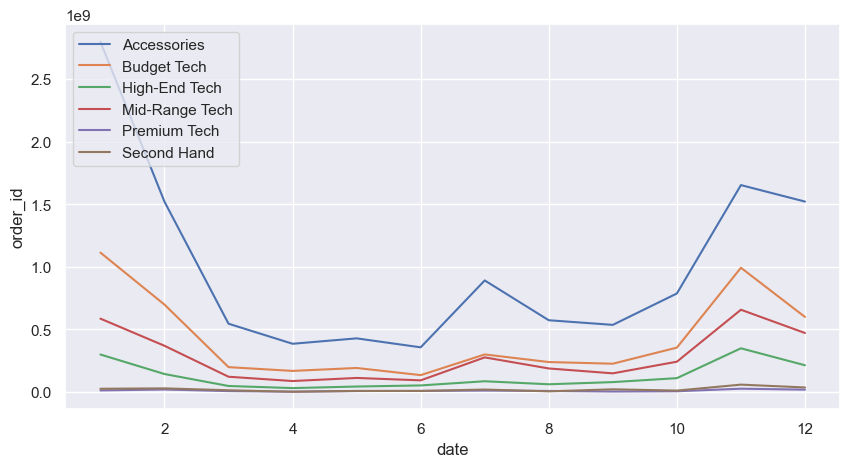

In [300]:
sns.set(rc={'figure.figsize':(10,5)})
a= discounts_df.copy()
a['date']=pd.to_datetime(a['date']).dt.month
a=a.groupby(["category", "date"]).agg({"order_id": "sum"})
amount_plot = sns.lineplot(data=a, x="date", y="order_id", hue="category",legend=True);
plt.legend(loc='upper left');

In [303]:
top_products = discounts_df.groupby("name").agg({"product_quantity":"sum", "actual_revenue":"sum"}).nlargest(10,"actual_revenue")
top_products

,product_quantity,actual_revenue
name,,
"LG 27UD88-W Monitor 27 ""UHD 4K USB 3.0 USB-C",241,136515.81
Apple iPhone 6 32GB Space Gray,270,104560.64
AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch,540,86960.26
Apple iPhone 64GB Space Gray 8,108,85301.93
Apple iPhone 32GB Space Gray,224,81124.76
"Apple MacBook Air 13 ""Core i5 18GHz | 8GB RAM | 128GB SSD",77,74964.06
Apple iPhone 8 Plus 64GB Gold,79,70721.79
"Red 4TB WD 35 ""Mac PC hard drive and NAS",478,65848.36
Apple iPhone 8 Plus 64GB Space Gray,67,60090.08


In [312]:
discounts_df["discount_type"].value_counts()

normal       22011
low or no    14482
high         12279
agressive     5353
Name: discount_type, dtype: int64

In [ ]:
#Model A        (Seosanl Change)
# To see what our total revenue in 2017 could be if we applied high and agressive discounts only in months 1, 2, 7, 11, 12
# In these months we see the change of customer behaviour in terms of getting the increase of orders.
# 1) We make a POTENTIAL REVENUE: price for months 3, 4, 5, 6, 8, 9, 10, where discount now was high and agressive, switches to product "price" for all categories.

#Model B      (Categorical Change)
# To see what our total revenue in 2017 could be if we removed discounts for some categories
# 1) Leaving agressive Discounts only for Second Hand and Accessories
# 2) Remove discounts for Premium Tech (accept months where they affect the increase of sales 1, 2, 7, 11, 12)


In [364]:
#Model A        (Seosanl Change)
# To see what our total revenue in 2017 could be if we applied high and agressive discounts only in months 1, 2, 7, 11, 12
# In these months we see the change of customer behaviour in terms of getting the increase of orders.
# 1) We make a POTENTIAL REVENUE: price for months 3, 4, 5, 6, 8, 9, 10, where discount now was high and agressive, switches to product "price" for all categories.

# filter rows that belong to year 2017
model_a_df_2017 = discounts_df.copy()
model_a_df_2017['year'] = pd.to_datetime(model_a_df_2017['date']).dt.year
model_a_df_2017['month'] = pd.to_datetime(model_a_df_2017['date']).dt.month
model_a_df_2017 = model_a_df_2017[model_a_df_2017['year'] == 2017]

# define a function to compute potential revenue
def compute_potential_revenue(row):
    if row['month'] in [3, 4, 5, 6, 8, 9, 10] and row['discount_type'] in ['agressive', 'high']:
        return row['product_quantity'] * row['price']
    else:
        return row['product_quantity'] * row['unit_price']

# apply the function to create the potential_revenue column
model_a_df_2017['potential_revenue'] = model_a_df_2017.apply(compute_potential_revenue, axis=1)

In [365]:
# MODEL A shows that we could have saved in 2017 -  246 138 EUR
model_a_df_2017["potential_saving"] = model_a_df_2017["potential_revenue"]-model_a_df_2017["actual_revenue"]
model_a_df_2017["actual_revenue"].sum(), model_a_df_2017["potential_revenue"].sum(), model_a_df_2017["potential_saving"].sum()

(6276362.359999999, 6522500.06, 246137.69999999995)

In [366]:
# MODEL A shows that we could have saved in 2017 for each category:
model_a_df_2017.groupby("category").agg({"actual_revenue":"sum", "potential_revenue":"sum", "potential_saving":"sum"})

,actual_revenue,potential_revenue,potential_saving
category,,,
Accessories,875138.07,941409.66,66271.59
Budget Tech,1252849.39,1285906.08,33056.69
High-End Tech,1771891.65,1829535.23,57643.58
Mid-Range Tech,1985494.54,2031708.07,46213.53
Premium Tech,203195.30,218636.21,15440.91
Second Hand,187793.41,215304.81,27511.40


In [367]:
#Model B      (Categorical Change)
# To see what our total revenue in 2017 could be if we removed discounts for some categories
# 1) Leaving agressive Discounts only for Second Hand and Accessories
# 2) Remove discounts for Premium Tech (accept months where they affect the increase of sales 1, 2, 7, 11, 12)
# filter rows that belong to year 2017
model_b_df_2017 = discounts_df.copy()
model_b_df_2017['year'] = pd.to_datetime(model_b_df_2017['date']).dt.year
model_b_df_2017['month'] = pd.to_datetime(model_b_df_2017['date']).dt.month
model_b_df_2017 = model_b_df_2017[model_b_df_2017['year'] == 2017]

# define a function to compute potential revenue based on the conditions
def compute_potential_revenue(row):
    if row['discount_type'] == 'agressive' and row['category'] not in ['Second Hand', 'Accessories']:
        return row['product_quantity'] * row['price']
    elif row['category'] == 'Premium Tech' and row['month'] not in [1, 2, 7, 11, 12]:
        return row['product_quantity'] * row['price']
    else:
        return row['product_quantity'] * row['unit_price']

# apply the function to create the potential_revenue column
model_b_df_2017['potential_revenue'] = model_b_df_2017.apply(compute_potential_revenue, axis=1)

In [368]:
# MODEL B shows that we could have saved in 2017 -  274 338 EUR
model_b_df_2017["potential_saving"] = model_b_df_2017["potential_revenue"]-model_b_df_2017["actual_revenue"]
model_b_df_2017["actual_revenue"].sum(), model_b_df_2017["potential_revenue"].sum(), model_b_df_2017["potential_saving"].sum()

(6276362.359999999, 6550700.56, 274338.2)

In [369]:
# MODEL B shows that we could have saved in 2017 for each category:
model_b_df_2017.groupby("category").agg({"actual_revenue":"sum", "potential_revenue":"sum", "potential_saving":"sum"})

,actual_revenue,potential_revenue,potential_saving
category,,,
Accessories,875138.07,875138.07,0.00
Budget Tech,1252849.39,1304142.62,51293.23
High-End Tech,1771891.65,1931348.76,159457.11
Mid-Range Tech,1985494.54,2021307.21,35812.67
Premium Tech,203195.30,230970.49,27775.19
Second Hand,187793.41,187793.41,0.00


In [381]:
#Model C      Remove all sales if it's not a sale season


model_c_df_2017 = discounts_df.copy()
model_c_df_2017['year'] = pd.to_datetime(model_c_df_2017['date']).dt.year
model_c_df_2017['month'] = pd.to_datetime(model_c_df_2017['date']).dt.month
model_c_df_2017 = model_c_df_2017[model_c_df_2017['year'] == 2017]

# define a function to compute potential revenue based on the conditions
def compute_potential_revenue(row):
    if row['month'] in [1, 2, 7, 11, 12]:
        return row['product_quantity'] * row['unit_price']
    elif row['category'] == 'Premium Tech' and row['discount_type'] in ['agressive', 'high']:
        return row['product_quantity'] * row['price']
    else:
        return row['product_quantity'] * row['price']

# apply the function to create the potential_revenue column
model_c_df_2017['potential_revenue'] = model_c_df_2017.apply(compute_potential_revenue, axis=1)

In [382]:
model_c_df_2017["potential_saving"] = model_c_df_2017["potential_revenue"]-model_c_df_2017["actual_revenue"]
model_c_df_2017["actual_revenue"].sum(), model_c_df_2017["potential_revenue"].sum(), model_c_df_2017["potential_saving"].sum()

(6276362.359999999, 6730623.749999999, 454261.39)

In [383]:
model_c_df_2017["potential_saving"].sum()*100/model_c_df_2017["actual_revenue"].sum()

7.23765397764574